In [1]:
from tqdm.notebook import tqdm
import datetime
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import os
import open3d as op3 
import seaborn as sns
import pandas as pd
import time
from scipy.sparse.csgraph import connected_components
import seaborn as sns
from open3d import JVisualizer
from BfTableGenerator import RansacCollector
from matplotlib import cm
from sklearn.cluster._dbscan_inner import dbscan_inner
from numpy.lib.stride_tricks import sliding_window_view


theta_raw = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0]
theta = np.sort(theta_raw)
azimuths = np.arange(0,360,0.2)

In [2]:
os.chdir(r'/Users/czhui960/Documents/Lidar/RawLidarData/FrameSamplingTest')
frame_set = np.arange(0,2000,1).astype('int')
collector = RansacCollector(pcap_path=r'./2020-7-27-10-30-0.pcap',frames_set = frame_set)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1,inuse_frame = frame_set)
# d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1 FrameSampling


  0%|          | 2/2000 [00:00<02:14, 14.89it/s]

Loading pcap...


  3%|▎         | 1/32 [00:00<00:05,  5.52it/s]

Generating Threshold Map


100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


In [3]:
from DDBSCAN import Raster_DBSCAN


In [10]:
Thred_map = collector.thred_map
db = Raster_DBSCAN(window_size=(7,7),eps = 1.5, min_samples= 10,Td_map_szie=Thred_map.shape)

In [20]:
Td_map = collector.td_maps[693].copy()
Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

42.5 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
td_freq_map = Td_map
Xs = []
Ys = []
Zs = []
Labels = []
for i in range(td_freq_map.shape[0]):
    longitudes = theta[i]*np.pi / 180
    latitudes = azimuths * np.pi / 180 
    hypotenuses = td_freq_map[i] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = td_freq_map[i] * np.sin(longitudes)
    Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
    Xs.append(X[Valid_ind])
    Ys.append(Y[Valid_ind])
    Zs.append(Z[Valid_ind])
    Labels.append(Labeling_map[i][Valid_ind])

    
Xs = np.concatenate(Xs)
Ys = np.concatenate(Ys)
Zs = np.concatenate(Zs)
Labels = np.concatenate(Labels).astype('int')
Colors = []
for i in range(len(Labels)):
    Colors.append(cm.tab20(Labels[i]%20)[:3])
Colors = np.array(Colors)
pcd = op3.geometry.PointCloud()
XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
pcd.points = op3.utility.Vector3dVector(XYZ)
pcd.colors = op3.utility.Vector3dVector(Colors)
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

## Prototype

In [56]:
"""
This method applys the vectorization calculation, 
where the TD map is chunked as multiple parts and corresponding neighbors in each center of chunk are counted and recorded.
The calculated neighbors are stored in the neighborhood list which is then treated as an input for the dbscan_inner() so as to
utilize the core CPP API from the sklearn. 

*** 
Step.1 -> Chunking output Subchunks including Td_map, Index_map, Foreground_map
Step.2 -> Neigborhoods calculation
Step.3 -> dbscan_inner()

"""

window_size = (9,9) #(height,width)
eps = 1.5
min_samples = 15
Thred_map = collector.thred_map
Height_fringe,Width_fringe = int(window_size[0]/2),int(window_size[1]/2)

Height_fringe_offset_fore = np.full((Height_fringe,Thred_map.shape[1] + 2 * Width_fringe),False)
Height_fringe_offset_td = np.full((Height_fringe,Thred_map.shape[1] + 2 * Width_fringe),200)
Heigh_fringe_offset_index = np.full((Height_fringe,Thred_map.shape[1] + 2 * Width_fringe),-1,dtype = np.int64)


In [106]:
Td_map = collector.td_maps[602].copy()
Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
# load Foreground and Td distance matrix 
rows,cols = np.where(Foreground_map)
indices = np.arange(len(rows),dtype = np.int64)
Index_map = -1*np.ones(shape = Foreground_map.shape,dtype=np.int64)
Index_map[rows,cols] = indices 

# azimuth padding 
Foreground_map_offset = np.concatenate([Foreground_map[:,-Width_fringe:],
                                        Foreground_map,
                                        Foreground_map[:,:Width_fringe]],axis = 1)
Index_map_offset = np.concatenate([Index_map[:,-Width_fringe:],
                                   Index_map,
                                   Index_map[:,:Width_fringe]],axis = 1)
Td_map_offset = np.concatenate([Td_map[:,-Width_fringe:],
                                Td_map,
                                Td_map[:,:Width_fringe]],axis = 1)
# laser padding 
Foreground_map_offset = np.concatenate([Height_fringe_offset_fore,
                                        Foreground_map_offset,
                                       Height_fringe_offset_fore])
Index_map_offset = np.concatenate([Heigh_fringe_offset_index,
                                  Index_map_offset,
                                  Heigh_fringe_offset_index])
Td_map_offset = np.concatenate([Height_fringe_offset_td,
                              Td_map_offset,
                              Height_fringe_offset_td])

Sub_indmap = sliding_window_view(Index_map_offset,window_size).reshape(-1,window_size[0],window_size[1])
Sub_tdmap = sliding_window_view(Td_map_offset,window_size).reshape(-1,window_size[0],window_size[1])
Sub_foremap = sliding_window_view(Foreground_map_offset,window_size).reshape(-1,window_size[0],window_size[1])


# Window inds that are valid as Foregound, and only 
valid_windows = Sub_foremap[:,Height_fringe,Width_fringe] 
Sub_indmap,Sub_foremap,Sub_tdmap = Sub_indmap[valid_windows],Sub_foremap[valid_windows],Sub_tdmap[valid_windows]

# key step
center_td_dist = Sub_tdmap[:,Height_fringe,Width_fringe]
valid_index = Sub_indmap[:,Height_fringe,Width_fringe]
temp = ((np.abs((Sub_tdmap - center_td_dist.reshape(-1,1,1))) < eps) & Sub_foremap)
neighborhoods = np.array([Sub_indmap[i][temp[i]] for i in range(len(temp))],dtype = 'O')
n_neighbors = np.array([len(neighbor) for neighbor in neighborhoods])
Labels = np.full(len(n_neighbors), -1, dtype=np.intp)
core_samples = np.asarray(n_neighbors >= min_samples,dtype=np.uint8)
dbscan_inner(core_samples, neighborhoods, Labels)

Labeling_map = -1*np.ones_like(Foreground_map)
Labeling_map[rows,cols] = Labels

In [109]:
np.unique(Labeling_map)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [107]:
td_freq_map = Td_map
Xs = []
Ys = []
Zs = []
Labels = []
for i in range(td_freq_map.shape[0]):
    longitudes = theta[i]*np.pi / 180
    latitudes = azimuths * np.pi / 180 
    hypotenuses = td_freq_map[i] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = td_freq_map[i] * np.sin(longitudes)
    Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
    Xs.append(X[Valid_ind])
    Ys.append(Y[Valid_ind])
    Zs.append(Z[Valid_ind])
    Labels.append(Labeling_map[i][Valid_ind])

    
Xs = np.concatenate(Xs)
Ys = np.concatenate(Ys)
Zs = np.concatenate(Zs)
Labels = np.concatenate(Labels).astype('int')
Colors = []
for i in range(len(Labels)):
    Colors.append(cm.tab20(Labels[i]%20)[:3])
Colors = np.array(Colors)
pcd = op3.geometry.PointCloud()
XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
pcd.points = op3.utility.Vector3dVector(XYZ)
pcd.colors = op3.utility.Vector3dVector(Colors)
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

# Frame Association 

In [ ]:
Frame_0 = Labeling_map.copy()
Frame_1 = Labeling_map.copy()
combined_label_map = np.array([Frame_0,Frame_1])
%%timeit
unique_piars,unique_counts = np.unique(combined_label_map.reshape((-1,2)),axis = 0,return_counts = True)
unique_piars,unique_counts = unique_piars[1:],unique_counts[1:]

In [13]:
t_con = []
points_num = []
for frame_id in tqdm(range(17000)):
    ti = time.time()
    Td_map = collector.td_maps[frame_id].copy()
    Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
    # load Foreground and Td distance matrix 
    rows,cols = np.where(Foreground_map)
    indices = np.arange(len(rows),dtype = np.int64)
    Index_map = -1*np.ones(shape = Foreground_map.shape,dtype=np.int64)
    Index_map[rows,cols] = indices 

    # azimuth padding 
    Foreground_map_offset = np.concatenate([Foreground_map[:,-Width_fringe:],
                                            Foreground_map,
                                            Foreground_map[:,:Width_fringe]],axis = 1)
    Index_map_offset = np.concatenate([Index_map[:,-Width_fringe:],
                                       Index_map,
                                       Index_map[:,:Width_fringe]],axis = 1)
    Td_map_offset = np.concatenate([Td_map[:,-Width_fringe:],
                                    Td_map,
                                    Td_map[:,:Width_fringe]],axis = 1)
    # laser padding 
    Foreground_map_offset = np.concatenate([Height_fringe_offset_fore,
                                            Foreground_map_offset,
                                           Height_fringe_offset_fore])
    Index_map_offset = np.concatenate([Heigh_fringe_offset_index,
                                      Index_map_offset,
                                      Heigh_fringe_offset_index])
    Td_map_offset = np.concatenate([Height_fringe_offset_td,
                                  Td_map_offset,
                                  Height_fringe_offset_td])

    Sub_indmap = sliding_window_view(Index_map_offset,window_size).reshape(-1,window_size[0],window_size[1])
    Sub_tdmap = sliding_window_view(Td_map_offset,window_size).reshape(-1,window_size[0],window_size[1])
    Sub_foremap = sliding_window_view(Foreground_map_offset,window_size).reshape(-1,window_size[0],window_size[1])


    # Window inds that are valid as Foregound, and only 
    valid_windows = Sub_foremap[:,Height_fringe,Width_fringe] 
    Sub_indmap,Sub_foremap,Sub_tdmap = Sub_indmap[valid_windows],Sub_foremap[valid_windows],Sub_tdmap[valid_windows]


    center_td_dist = Sub_tdmap[:,Height_fringe,Width_fringe]
    valid_index = Sub_indmap[:,Height_fringe,Width_fringe]
    temp = ((np.abs((Sub_tdmap - center_td_dist.reshape(-1,1,1))) < eps) & Sub_foremap)
    neighborhoods = np.array([Sub_indmap[i][temp[i]] for i in range(len(temp))],dtype = 'O')
    n_neighbors = np.array([len(neighbor) for neighbor in neighborhoods])
    Labels = np.full(len(n_neighbors), -1, dtype=np.intp)
    core_samples = np.asarray(n_neighbors >= min_samples,
                              dtype=np.uint8)
    dbscan_inner(core_samples, neighborhoods, Labels)

    # rows,cols = rows[valid_index],cols[valid_index]
    Labeling_map = -1*np.ones_like(Foreground_map)
    Labeling_map[rows,cols] = Labels
    t_con.append(1000*(time.time() - ti))
    points_num.append(len(Labels))

# DBSCAN

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
db = DBSCAN(eps=1.5,min_samples=10)


In [27]:
time_consumption = []
for frame_ind in tqdm(range(17000)):
    ti = time.time()
    Td_map = collector.td_maps[frame_ind].copy()
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    Labels = db.fit_predict(XYZ)
    time_consumption.append(1000*(time.time() - ti))

KeyboardInterrupt: 

In [38]:
points_num_db = points_num[:len(time_consumption)]

In [40]:
points_num_db = np.array(points_num_db)

In [42]:
time_consumption = np.array(time_consumption)
t_con = np.array(t_con)
points_num = np.array(points_num)

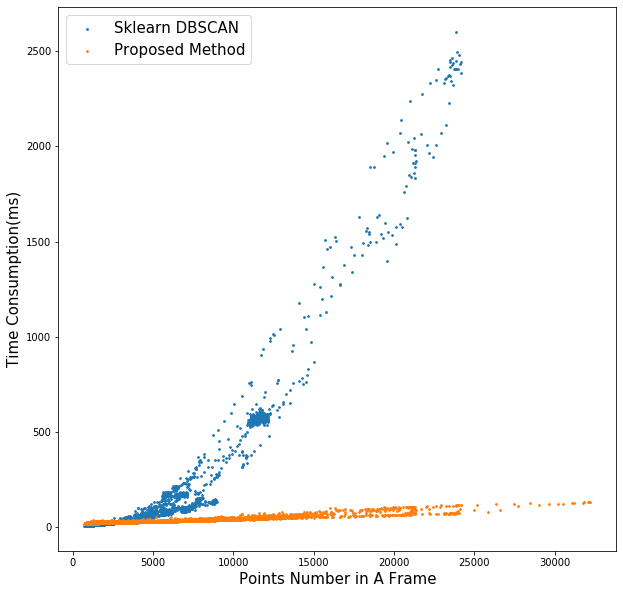

In [37]:
plt.figure(figsize = (10,10))
plt.scatter(points_num[:len(time_consumption)],time_consumption,s = 3,label = 'Sklearn DBSCAN')
plt.scatter(points_num,t_con,s = 3,label = 'Proposed Method')
plt.legend(fontsize = 15)
plt.xlabel('Points Number in A Frame',fontsize = 15)
plt.ylabel('Time Consumption(ms)',fontsize = 15)
plt.show()

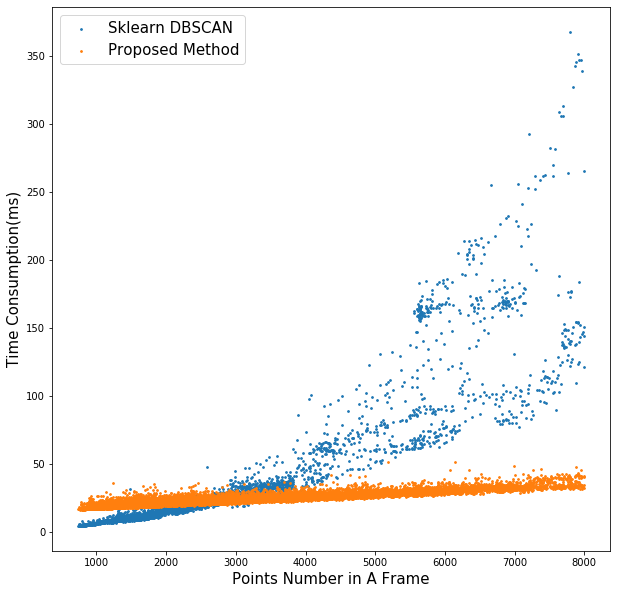

In [46]:
plt.figure(figsize = (10,10))
plt.scatter(points_num_db[points_num_db<8000],time_consumption[points_num_db<8000],s = 3,label = 'Sklearn DBSCAN')
plt.scatter(points_num[points_num < 8000],t_con[points_num < 8000],s = 3,label = 'Proposed Method')
plt.legend(fontsize = 15)
plt.xlabel('Points Number in A Frame',fontsize = 15)
plt.ylabel('Time Consumption(ms)',fontsize = 15)
plt.show()

## Test 

In [38]:
from DDBSCAN import Raster_DBSCAN
import os 
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
from matplotlib import cm
TIF = Image.open(r'./seg/140WA_-_000140WA16900RGB_intCluster.tif')
Tif_arr = np.array(TIF)
db = Raster_DBSCAN(window_size=(7,7),eps = 10, min_samples= 20)
Mask = Tif_arr > 0
result = db.fit_predict(Td_map= Tif_arr,Foreground_map=Mask)
plt.figure(figsize=(10,10))
plt.imshow(result,cmap = cm.tab20)
plt.show()

69.9 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


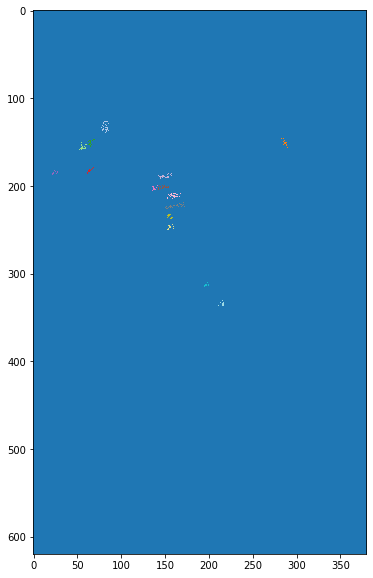

In [53]:
TIF = Image.open(r'./seg/140WA_-_000140WA16900RGB_intCluster.tif')
Tif_arr = np.array(TIF)
db = Raster_DBSCAN(window_size=(7,7),eps = 10, min_samples= 12)
Mask = ((150 < Tif_arr) & ( Tif_arr < 190)) | ((210 < Tif_arr) & ( Tif_arr < 230))
%timeit result = db.fit_predict(Td_map= Tif_arr,Foreground_map=Mask)
plt.figure(figsize=(10,10))
plt.imshow(result,cmap = cm.tab20)
plt.show()

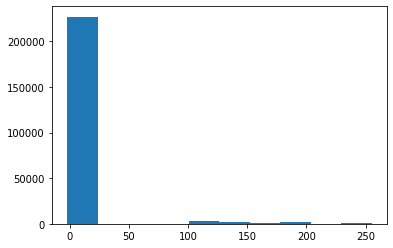

In [27]:
plt.hist(Tif_arr.flatten())
plt.show()

In [2]:
db = Raster_DBSCAN(window_size=(7,7),eps = 10, min_samples= 20)

In [34]:
Mask = Tif_arr > 0
result = db.fit_predict(Td_map= Tif_arr,Foreground_map=Mask)

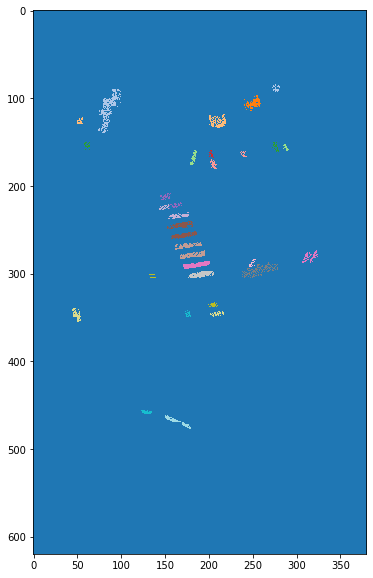

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(result,cmap = cm.tab20)
plt.show()